In [1]:
import numpy as np
import os
import random
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from utils import *

%matplotlib inline

2023-07-11 11:54:20.893085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 11:54:22.074537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["PYTHONHASHSEED"] = "0"
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
folder_path = './points'

x, y = read_data(folder_path, people=["joel"])

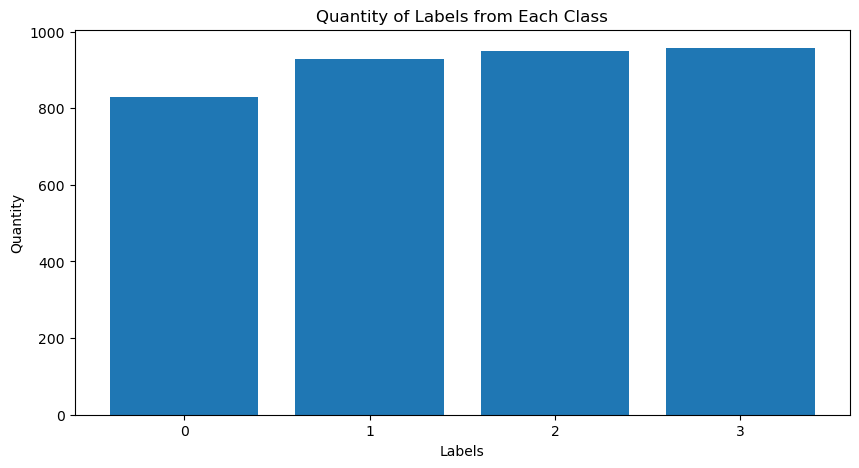

[0 1 2 3]
4


In [4]:
draw_bar_chart(y)

print(np.unique(y))

n_classes = len(np.unique(y))

print(n_classes)

In [5]:
# shuffle
x, y = shuffle(x, y, random_state=0)

# split
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=1/5, random_state=0, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=1/4, random_state=0, stratify=y_temp, shuffle=True)

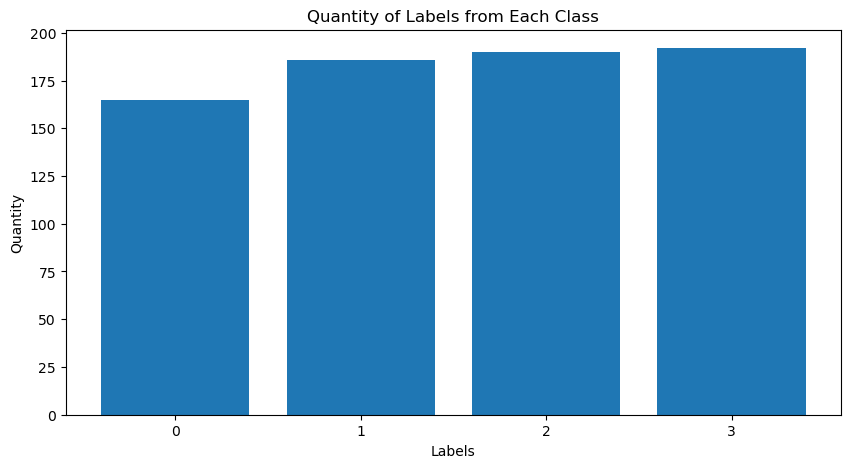

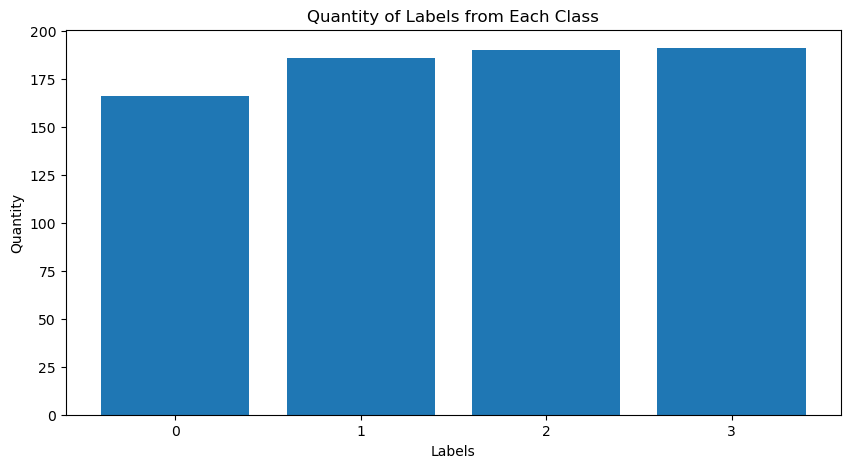

In [6]:
draw_bar_chart(y_val)
draw_bar_chart(y_test)

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.5,
    mlp_dropout=0.5,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.Flatten()(x)

    #x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def create_model(input_shape, mlp_dropout=0.1, dropout=0.5, learning_rate=0.0001):
    model = build_model(
        input_shape,
        head_size=32,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=2,
        mlp_units=[128,32],
        mlp_dropout=mlp_dropout,
        dropout=dropout,
    )

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["sparse_categorical_accuracy"]
    )

    return model

In [ ]:
all_results = []

for _ in range(5):
    input_shape = x.shape[1:]

    model = create_model(input_shape)

    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

    results = model.fit(
        x_train,
        y_train,
        validation_data=(x_val,y_val),
        epochs=10000,
        batch_size=256,
        callbacks=callbacks,
    )

    model.evaluate(x_val, y_val, verbose=1)

    l, a = model.evaluate(x_test, y_test, verbose=1)

    all_results.append([l, a])

2023-07-11 11:54:28.638059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 11:54:28.800103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 11:54:28.800779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 3)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 21, 3)       6           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 21, 3)       1923        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

2023-07-11 11:54:44.618123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-11 11:54:46.408764: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1efa3f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-11 11:54:46.408818: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-07-11 11:54:46.915485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-11 11:54:48.784340: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 16s 115ms/step - loss: 2.1479 - sparse_categorical_accuracy: 0.2553 - val_loss: 1.5876 - val_sparse_categorical_accuracy: 0.2538
Epoch 2/10000
9/9 [==============================] - 0s 35ms/step - loss: 1.9622 - sparse_categorical_accuracy: 0.2549 - val_loss: 1.4821 - val_sparse_categorical_accuracy: 0.2633
Epoch 3/10000
9/9 [==============================] - 0s 35ms/step - loss: 1.7881 - sparse_categorical_accuracy: 0.2567 - val_loss: 1.4273 - val_sparse_categorical_accuracy: 0.2087
Epoch 4/10000
9/9 [==============================] - 0s 34ms/step - loss: 1.7185 - sparse_categorical_accuracy: 0.2599 - val_loss: 1.3979 - val_sparse_categorical_accuracy: 0.2087
Epoch 5/10000
9/9 [==============================] - 0s 35ms/step - loss: 1.6304 - sparse_categorical_accuracy: 0.2690 - val_loss: 1.3792 - val_sparse_categorical_accuracy: 0.2660
Epoch 6/10000
9/9 [==============================] - 0s 35ms/step - loss: 1.6024 - sparse_categorical_accuracy: 

9/9 [==============================] - 0s 36ms/step - loss: 0.7120 - sparse_categorical_accuracy: 0.7142 - val_loss: 0.6416 - val_sparse_categorical_accuracy: 0.7408
Epoch 237/10000
9/9 [==============================] - 0s 36ms/step - loss: 0.7110 - sparse_categorical_accuracy: 0.7096 - val_loss: 0.6404 - val_sparse_categorical_accuracy: 0.7394
Epoch 238/10000
9/9 [==============================] - 0s 37ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.6379 - val_sparse_categorical_accuracy: 0.7422
Epoch 239/10000
9/9 [==============================] - 0s 48ms/step - loss: 0.7026 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.6366 - val_sparse_categorical_accuracy: 0.7422
Epoch 240/10000
9/9 [==============================] - 0s 42ms/step - loss: 0.6856 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.6360 - val_sparse_categorical_accuracy: 0.7408
Epoch 241/10000
9/9 [==============================] - 0s 45ms/step - loss: 0.7205 - sparse_categorical_ac

In [ ]:
print(all_results)

[[0.32775968313217163, 0.9147496819496155], [0.2758471369743347, 0.9377537369728088], [0.31419190764427185, 0.9161028265953064], [0.2982747256755829, 0.9269282817840576], [0.27334317564964294, 0.9255750775337219]]


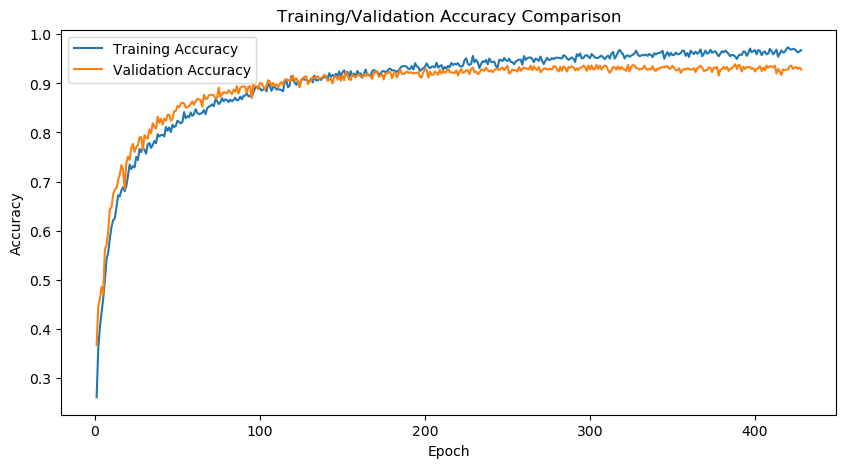

In [ ]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

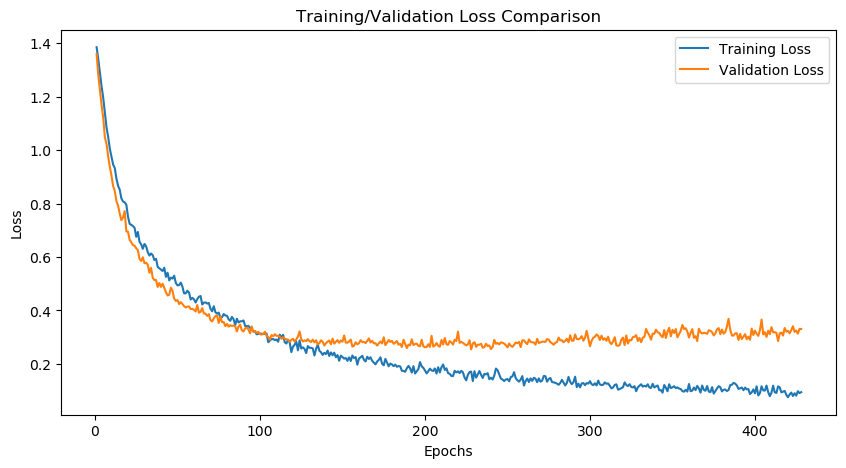

In [ ]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

24/24 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       171
           1       0.94      0.93      0.94       183
           2       0.94      0.89      0.91       198
           3       0.95      0.96      0.95       187

    accuracy                           0.93       739
   macro avg       0.93      0.93      0.93       739
weighted avg       0.93      0.93      0.93       739



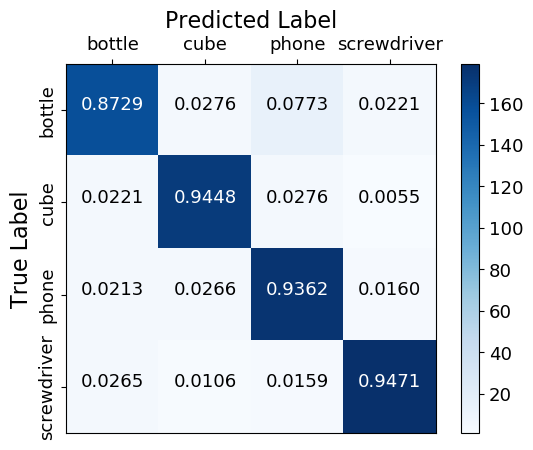

In [ ]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
print(classification_report(y_pred,y_test))
plot_confusion_matrix(y_test, y_pred, ["bottle", "cube", "phone", "screwdriver"])